In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx

In [2]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

Xorig: (485, 414)  X: (73, 62)


/home/ubuntu/Mody/env_cs/lib/python3.4/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


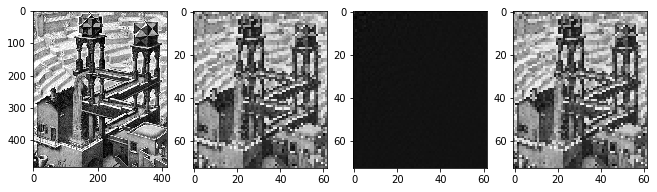

In [18]:
# read original image and downsize for speed
Xorig = spimg.imread('../images/escher_waterfall2.JPG', flatten=True, mode='L') # read in grayscale
X = spimg.zoom(Xorig, 0.15)
ny,nx = X.shape
print ('Xorig:', Xorig.shape, ' X:', X.shape)

f, axarr = plt.subplots(1,4, figsize=(11,11))
axarr[0].imshow(Xorig, cmap=plt.cm.gray)
axarr[1].imshow(X, cmap=plt.cm.gray)
X_dct = dct2(X)
axarr[2].imshow(X_dct, cmap=plt.cm.gray)
axarr[3].imshow(idct2(X_dct), cmap=plt.cm.gray)

In [19]:
# extract small sample of signal
k = round(nx * ny * 0.5) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = X.T.flat[ri]
b = np.expand_dims(b, axis=1)

# create dct matrix operator using kron (memory errors for large ny*nx)
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[ri,:] # same as phi times kron
print (A.shape)

(2263, 4526)


In [13]:
# do L1 optimization
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +2e+07  1e+00  1e-02  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  +1.215e+04  +1.236e+04  +1e+07  9e-01  5e-03  2e+02  1e+03  0.6529  1e-01   1  1  1 |  0  0
 2  +2.060e+04  +2.066e+04  +1e+06  6e-01  7e-04  5e+01  2e+02  0.8798  3e-02   1  0  1 |  0  0
 3  +5.513e+04  +5.515e+04  +5e+05  3e-01  2e-04  2e+01  5e+01  0.7030  4e-02   1  0  0 |  0  0
 4  +1.004e+05  +1.004e+05  +1e+05  7e-02  6e-05  6e+00  1e+01  0.7561  3e-02   1  0  1 |  0  0
 5  +1.196e+05  +1.196e+05  +5e+04  3e-02  2e-05  3e+00  5e+00  0.6572  6e-02   1  0  1 |  0  0
 6  +1.262e+05  +1.262e+05  +2e+04  1e-02  1e-05  1e+00  2e+00  0.6618  2e-01   1  1  1 |  0  0
 7  +1.289e+05  +1.289e+05  +1e+04  6e-03  5e-06  8e-01  1e+00  0.6697  2e-01   1  1  1 |  0  0
 8  +1.302e+05  +1.302e+05  +4e+03  2e-03  2e-

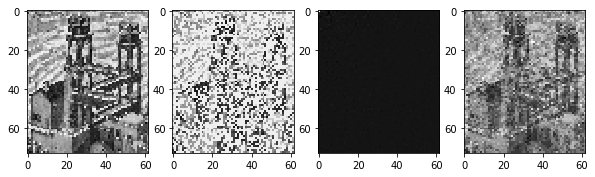

In [25]:
# reconstruct signal
Xat = Xat2.reshape(nx, ny).T # stack columns
Xa = idct2(Xat)

# create images of mask (for visualization)
mask = np.zeros(X.shape)
mask.T.flat[ri] = 255
Xm = 255 * np.ones(X.shape)
Xm.T.flat[ri] = X.T.flat[ri]


f, axarr = plt.subplots(1,4, figsize=(10,10))
axarr[0].imshow(X, cmap = plt.cm.gray)
axarr[1].imshow(Xm, cmap = plt.cm.gray)
axarr[2].imshow(Xat, cmap = plt.cm.gray)
axarr[3].imshow(Xa, cmap = plt.cm.gray)